In [10]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset

import numpy as np
import matplotlib.pyplot as plt

# Set the background color
plt.style.use('dark_background')

In [1]:
class ReverseIntensity:
    def __call__(self, x):
        return 1 - x

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [5]:
Net()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [42]:
transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize(32),
            transforms.ToTensor(),
            ReverseIntensity(),
            transforms.Pad(32-1, padding_mode='reflect'),
            transforms.RandomRotation(45),
            transforms.CenterCrop(28),
            # transforms.RandomAffine(degrees=30, translate=(0.5, 0.5), scale=(0.25, 1), shear=(-30, 30, -30, 30)),
            transforms.Normalize((0.1307,), (0.3081,))
])

In [43]:
path = '/home/teerawat.c/projects/handwritten-onnx-js/models/thai-numerals/dataloader/data'
batch_size = 16

In [44]:
dataset = ImageFolder(path, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [45]:
images, labels = next(iter(train_loader))

((28, 28, 1), tensor(0), <matplotlib.image.AxesImage at 0x7fd33f97ee10>)

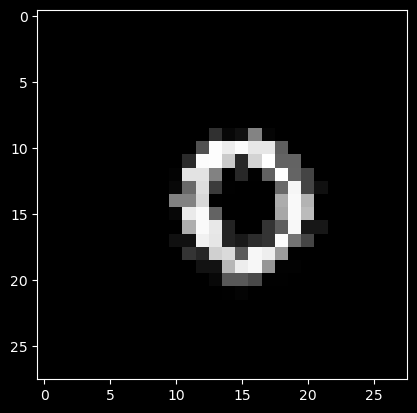

In [46]:
i = 10
image = images[i].numpy().transpose((1, 2, 0))
image.shape, labels[i], plt.imshow(image, cmap='gray')

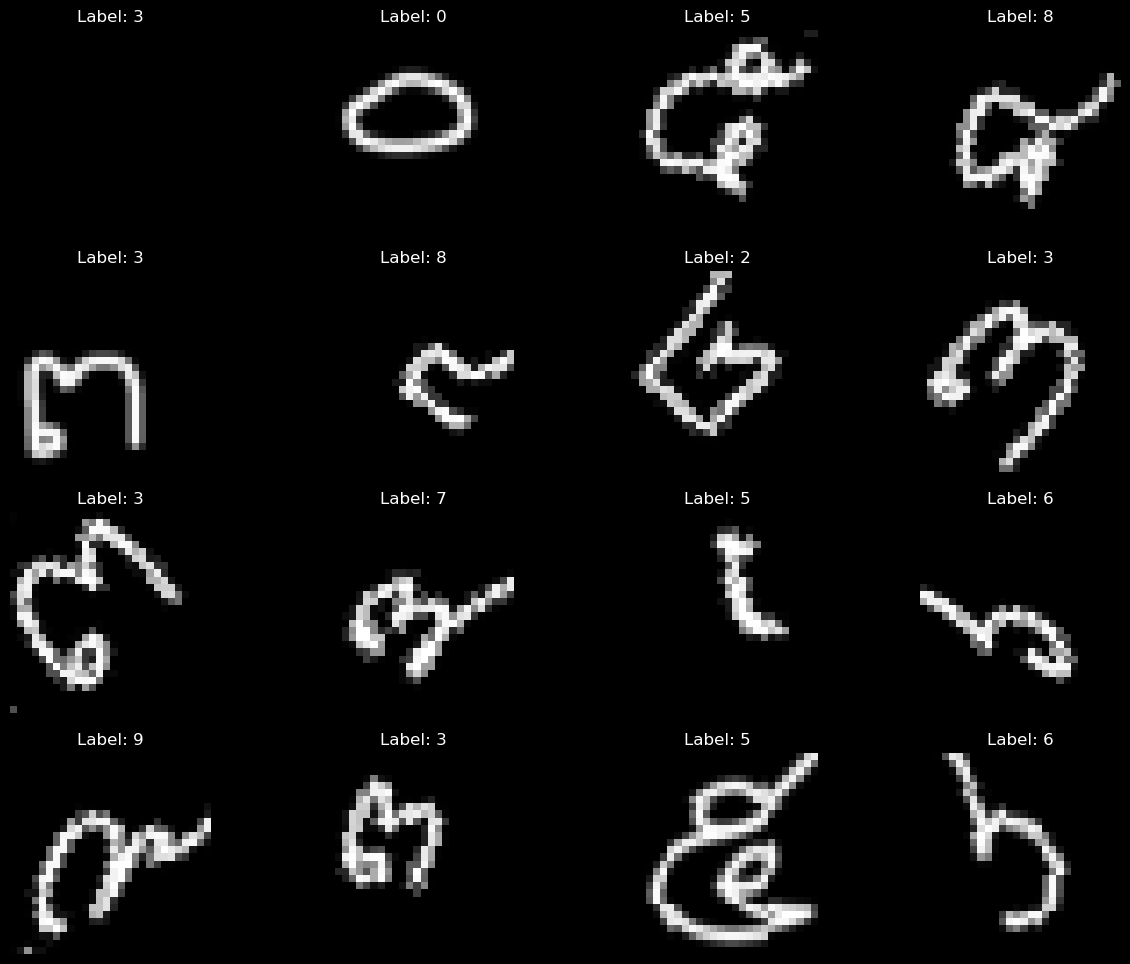

In [47]:
fig, axes = plt.subplots(4, 4, figsize=(15, 12))  # 4x4 grid for 16 images
axes = axes.flatten()

images, labels = next(iter(train_loader))
for idx, (img ,label, ax) in enumerate(zip(images, labels, axes)):
    image = img.numpy().transpose((1, 2, 0))

    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Label: {label}")

In [48]:
def get_dataset_stats(loader):
    label_count = {}
    total_samples = 0
    
    # Iterate through the DataLoader
    for images, labels in loader:
        total_samples += labels.size(0)  # Count total number of samples
        for label in labels:
            if label.item() in label_count:
                label_count[label.item()] += 1
            else:
                label_count[label.item()] = 1
    
    return label_count, total_samples

In [49]:
# Assuming train_loader and test_loader are already defined
train_label_count, train_total_samples = get_dataset_stats(train_loader)
test_label_count, test_total_samples = get_dataset_stats(test_loader)

# Print train dataset stats
print("📃Train Dataset:")
for label, count in train_label_count.items():
    print(f"\tNumber of images in class {label}: {count}")
print(f"\tNumber of training samples: {train_total_samples}")

# Print test dataset stats
print("📃Test Dataset:")
for label, count in test_label_count.items():
    print(f"\tNumber of images in class {label}: {count}")
print(f"\tNumber of testing samples: {test_total_samples}")

📃Train Dataset:
	Number of images in class 0: 318
	Number of images in class 4: 309
	Number of images in class 9: 312
	Number of images in class 1: 327
	Number of images in class 6: 304
	Number of images in class 2: 310
	Number of images in class 8: 315
	Number of images in class 7: 299
	Number of images in class 5: 299
	Number of images in class 3: 312
	Number of training samples: 3105
📃Test Dataset:
	Number of images in class 6: 84
	Number of images in class 1: 62
	Number of images in class 3: 76
	Number of images in class 4: 79
	Number of images in class 0: 70
	Number of images in class 7: 89
	Number of images in class 9: 76
	Number of images in class 5: 89
	Number of images in class 2: 79
	Number of images in class 8: 73
	Number of testing samples: 777


In [ ]:
def train(class_names, model, optimizer, loss_fn, train_loader, test_loader, epochs=10, writer=None, checkpoint_path=None, device='cpu'):
    ### START CODE HERE ###

    if writer:
        model_name = writer
        writer = SummaryWriter(f'runs/{class_names[0]}_{class_names[1]}/{model_name}/')

    # Move model to the appropriate device (CPU or GPU)
    model.to(device)

    # Begin training loop
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        train_loss, train_correct = 0, 0
        for batch_idx, (inputs, labels) in enumerate(train_loader):

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()                   # set zero the gradients to prepare for a new update.

            outputs = model(inputs)                 # Forward pass: compute predicted outputs

            outputs = outputs.squeeze()

            loss = loss_fn(outputs, labels)         # Calculate loss
            train_loss += loss.item()
            loss.backward()                         # Backward pass: compute gradient of the loss w.r.t. model parameters

            optimizer.step()                        # Perform a single optimization step (parameter update)

            # Calculate accuracy
            # predicted = torch.round(outputs).type(torch.long)   # binary classification
            _, predicted = torch.max(outputs, 1)              # multiple classification
            train_correct += (predicted == labels).sum().item()

        # Switch to evaluation mode for testing the model
        model.eval()
        test_loss, test_correct = 0, 0
        with torch.no_grad():                       # No gradients need to be computed for evaluation
            for inputs, labels in test_loader:

                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)             # Forward pass: compute predicted outputs

                outputs = outputs.squeeze()

                loss = loss_fn(outputs, labels)     # Calculate loss
                test_loss += loss.item()
                
                # Calculate accuracy
                # predicted = torch.round(outputs).type(torch.long)   # binary classification
                _, predicted = torch.max(outputs, 1)              # multiple classification
                test_correct += (predicted == labels).sum().item()

        # Calculate average losses and accuracy
        train_loss /= len(train_loader)
        train_accuracy = train_correct / len(train_loader.dataset)
        
        test_loss /= len(test_loader)
        test_accuracy = test_correct / len(test_loader.dataset)

        # Log testing loss and accuracy to TensorBoard every batches
        if writer:
            writer.add_scalar('Loss/train', train_loss, epoch)
            writer.add_scalar('Accuracy/train', train_accuracy, epoch)
            writer.add_scalar('Loss/test', test_loss, epoch)
            writer.add_scalar('Accuracy/test', test_accuracy, epoch)

        # Log the metrics per epoch
        print(f'Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f} - Acc: {train_accuracy:.4f} - Val Loss: {test_loss:.4f} - Val Acc: {test_accuracy:.4f}')

    # Save the model after the last epoch
    if checkpoint_path:
        checkpoint_path = f'{checkpoint_path}/{class_names[0]}_{class_names[1]}/{model_name}.pth'
        torch.save(model.state_dict(), checkpoint_path)
        print(f'Model saved to {checkpoint_path}')

    ### END CODE HERE ###